# Calibrating a Differentiable SIR Model

This tutorial demonstrates how to use **emidm**'s differentiable SIR model to:

1. Simulate synthetic epidemic data with known parameters
2. Fit the transmission rate (β) using gradient-based optimization
3. Compare the fitted model to the ground truth

This is a key use case for differentiable epidemiological models: we can use automatic differentiation to efficiently calibrate model parameters to observed data.

## Setup

First, let's import the necessary modules. This example requires JAX and Optax, which can be installed with:

```bash
pip install emidm[jax]
```

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from emidm.diff import DiffConfig, run_diff_sir
from emidm.optim import optimize_params

## Step 1: Generate Synthetic Data

We'll simulate an epidemic using the differentiable SIR model with a known transmission rate β = 0.35. This will serve as our "observed" data that we'll try to recover through optimization.

The differentiable SIR model uses **Gumbel-Softmax** sampling to make the stochastic transitions differentiable. The `DiffConfig` controls:
- `tau`: temperature parameter (lower = more discrete-like)
- `hard`: whether to use straight-through gradients

In [2]:
# True parameters
BETA_TRUE = 0.35
GAMMA = 0.2
N_AGENTS = 200
T = 30
I0 = 5

# Generate synthetic data
key = jax.random.PRNGKey(42)
data = run_diff_sir(
    N_agents=N_AGENTS,
    I0=I0,
    beta=BETA_TRUE,
    gamma=GAMMA,
    T=T,
    config=DiffConfig(tau=0.8, hard=True),
    key=key,
)

print(f"Generated epidemic with β = {BETA_TRUE}")
print(f"Peak infections: {int(data['I'].max())} at day {int(jnp.argmax(data['I']))}")

Generated epidemic with β = 0.35
Peak infections: 46 at day 18


Let's visualize the synthetic epidemic:

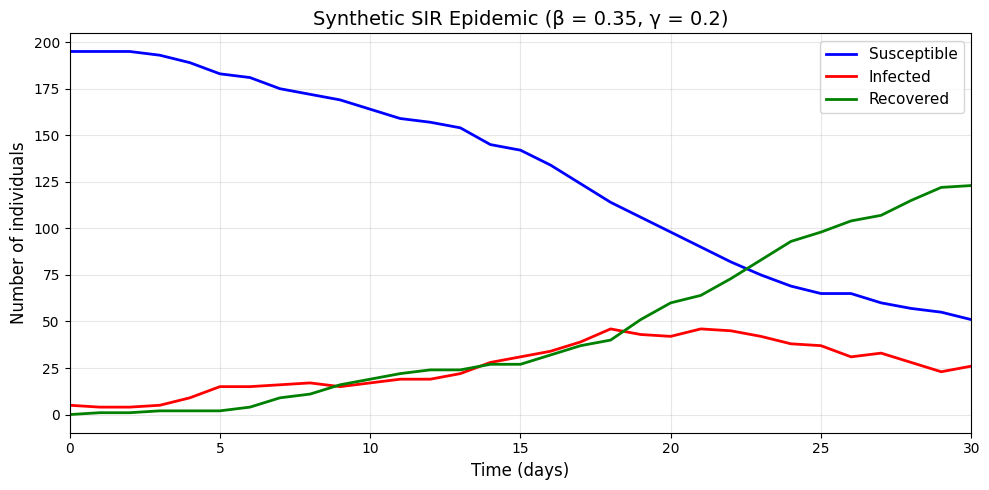

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

t = jnp.arange(T + 1)
ax.plot(t, data["S"], label="Susceptible", color="blue", linewidth=2)
ax.plot(t, data["I"], label="Infected", color="red", linewidth=2)
ax.plot(t, data["R"], label="Recovered", color="green", linewidth=2)

ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("Number of individuals", fontsize=12)
ax.set_title(f"Synthetic SIR Epidemic (β = {BETA_TRUE}, γ = {GAMMA})", fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim(0, T)

plt.tight_layout()
plt.show()

## Step 2: Define the Loss Function

To fit the model, we need a loss function that measures how well a given β reproduces the observed infection curve. We'll use **mean squared error** between the predicted and observed number of infected individuals.

Because `run_diff_sir` is differentiable, JAX can compute gradients of this loss with respect to β.

In [4]:
# The observed infection curve we want to fit
observed_I = data["I"]

def loss_fn(beta):
    """Compute MSE between predicted and observed infections."""
    pred = run_diff_sir(
        N_agents=N_AGENTS,
        I0=I0,
        beta=beta,
        gamma=GAMMA,
        T=T,
        config=DiffConfig(tau=0.8, hard=True),
        key=jax.random.PRNGKey(0),  # Fixed key for reproducibility during optimization
    )
    return jnp.mean((pred["I"] - observed_I) ** 2)

# Test the loss function
test_beta = jnp.array(0.15)
print(f"Loss at β = 0.15: {loss_fn(test_beta):.2f}")
print(f"Loss at β = 0.35 (true): {loss_fn(jnp.array(BETA_TRUE)):.2f}")

Loss at β = 0.15: 603.97
Loss at β = 0.35 (true): 40.06


## Step 3: Optimize β Using Gradient Descent

Now we'll use `optimize_params` to find the β that minimizes the loss. This function uses **Optax** (specifically, the Adam optimizer) under the hood.

We start from an initial guess of β = 0.15 and let the optimizer find the true value.

In [5]:
# Initial guess (deliberately wrong)
beta_init = jnp.array(0.15)

# Run optimization
beta_hat, history = optimize_params(
    loss_fn=loss_fn,
    init_params=beta_init,
    n_steps=150,
    learning_rate=0.01,
)

print(f"\nOptimization complete!")
print(f"  Initial β: {float(beta_init):.3f}")
print(f"  Fitted β:  {float(beta_hat):.3f}")
print(f"  True β:    {BETA_TRUE:.3f}")
print(f"  Error:     {abs(float(beta_hat) - BETA_TRUE):.4f}")


Optimization complete!
  Initial β: 0.150
  Fitted β:  0.393
  True β:    0.350
  Error:     0.0429


Let's visualize the optimization trajectory:

KeyError: 'params'

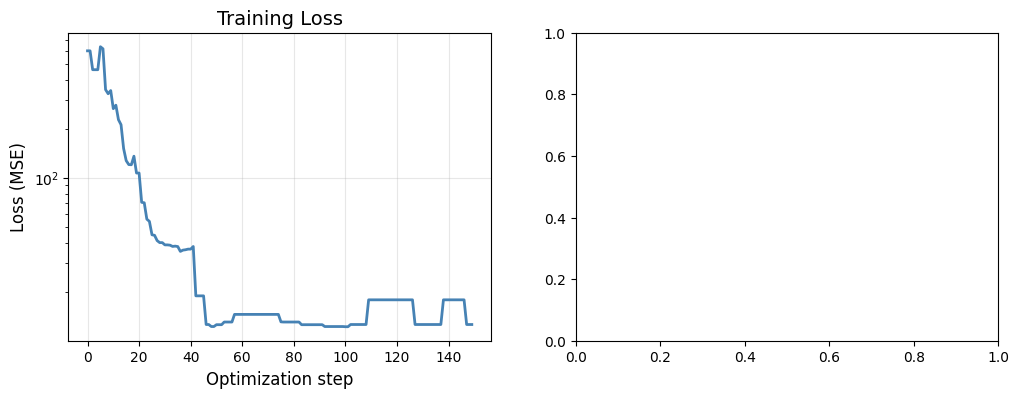

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# Loss curve
ax.plot(history["loss"], color="steelblue", linewidth=2)
ax.set_xlabel("Optimization step", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Training Loss", fontsize=14)
ax.set_yscale("log")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Compare Fitted vs True Model

Finally, let's compare the epidemic curves from:
- The **true** model (β = 0.35)
- The **fitted** model (β ≈ estimated value)
- The **initial** model (β = 0.15)

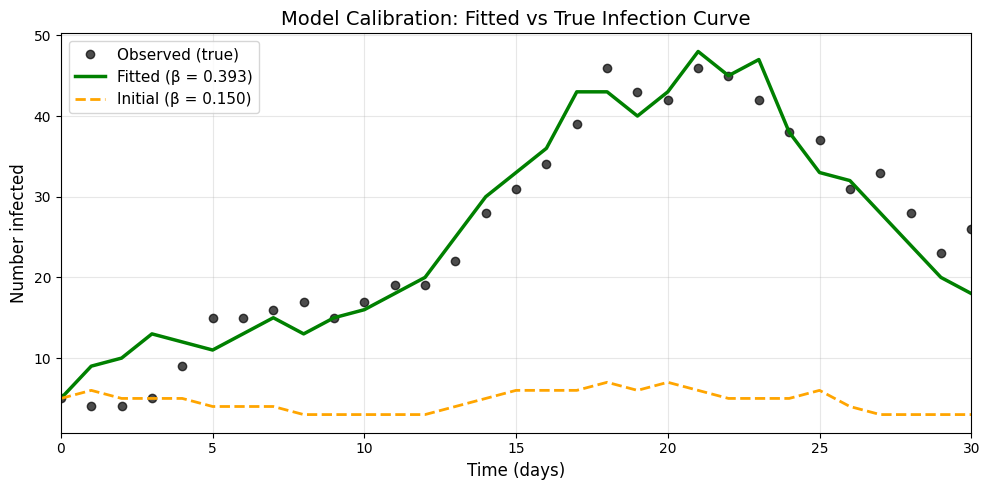

In [7]:
# Generate predictions with fitted and initial parameters
pred_fitted = run_diff_sir(
    N_agents=N_AGENTS, I0=I0, beta=beta_hat, gamma=GAMMA, T=T,
    config=DiffConfig(tau=0.8, hard=True), key=jax.random.PRNGKey(0),
)

pred_initial = run_diff_sir(
    N_agents=N_AGENTS, I0=I0, beta=beta_init, gamma=GAMMA, T=T,
    config=DiffConfig(tau=0.8, hard=True), key=jax.random.PRNGKey(0),
)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))

t = jnp.arange(T + 1)
ax.plot(t, observed_I, "o", color="black", markersize=6, label="Observed (true)", alpha=0.7)
ax.plot(t, pred_fitted["I"], "-", color="green", linewidth=2.5, label=f"Fitted (β = {float(beta_hat):.3f})")
ax.plot(t, pred_initial["I"], "--", color="orange", linewidth=2, label=f"Initial (β = {float(beta_init):.3f})")

ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("Number infected", fontsize=12)
ax.set_title("Model Calibration: Fitted vs True Infection Curve", fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim(0, T)

plt.tight_layout()
plt.show()

## Summary

In this tutorial, we demonstrated:

1. **Differentiable simulation**: Using `run_diff_sir` to simulate epidemics with gradients
2. **Gradient-based calibration**: Using `optimize_params` to fit model parameters
3. **Model comparison**: Visualizing how well the fitted model recovers the true dynamics

The key advantage of differentiable models is that we can use efficient gradient-based optimization instead of slower derivative-free methods (like grid search or MCMC). This becomes especially important for:

- **High-dimensional parameter spaces**: When fitting many parameters simultaneously
- **Complex models**: Where each simulation is computationally expensive
- **Uncertainty quantification**: Combining with variational inference or Hamiltonian Monte Carlo

See the [API documentation](../api.rst) for more details on the available models and utilities.